In [ ]:
import pandas as pd
import numpy as np
import os

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = [12.0, 4.0]
# plt.rcParams['figure.dpi'] = 80


from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.model_selection import KFold

In [2]:
def get_train_sample(X, y, n, bot_rate=0.1):
    X_bot = X[y==1].values
    X_user = X[y==0].values
    
    if bot_rate<1:
        n_bot = int(bot_rate * n)
    else:
        n_bot = int(bot_rate)
    assert n_bot < n
    
    bot_indexes = np.random.choice(np.arange(X_bot.shape[0]), size=n_bot, replace=False)
    X_train_bot = X_bot[bot_indexes]
    user_indexes = np.random.choice(np.arange(X_user.shape[0]), size=n - n_bot, replace=False)
    X_train_user = X_user[user_indexes]
    return np.vstack((X_train_bot, X_train_user)), np.hstack((np.ones(n_bot), np.zeros(n - n_bot))).reshape(-1, 1)

def get_random_sample(X, y, n):
    choosen_indexes = np.random.choice(X.index, size=n, replace=False)
    X_random = X.loc[choosen_indexes]
    y_random = y.loc[choosen_indexes].values
    return X_random, y_random


def plot_2d_distr_scatter(X_sample, y_sample, labels=None):
    label_1 = np.where(y_sample==1)[0]
    label_0 = np.where(y_sample==0)[0]
    plot_number = 2 if labels!=None else 1
    
    plt.figure(figsize=(12,5))
    gs = gridspec.GridSpec(1, plot_number)        
    ax1 = plt.subplot(gs[0, 0])
    ax1.set_title('Реальное распределение ботов')
    plt.scatter(X_sample[label_1, 0], X_sample[label_1, 1], 10, c='r', label='bot')
    plt.scatter(X_sample[label_0, 0], X_sample[label_0, 1], 2, c='g', label='user')
    ax1.legend()

    if labels!=None:
        ax2 = plt.subplot(gs[0, 1])
        label_1 = np.where(labels==1)[0]
        label_0 = np.where(labels==0)[0]
        ax2.set_title('Распределение меток')
        ax2.scatter(X_sample[label_1, 0], X_sample[label_1, 1], 10, c='r', label='label 1')
        ax2.scatter(X_sample[label_0, 0], X_sample[label_0, 1], 2, c='g', label='label 0')
        ax2.legend()
    plt.show()


def plot_3d_distr_scatter(X_sample, y_sample, labels=None):
    label_1 = np.where(y_sample==1)[0]
    label_0 = np.where(y_sample==0)[0]
    plot_number = 2 if labels!=None else 1
    
    fig = plt.figure(figsize=[12,5])
    ax1 = fig.add_subplot(1, plot_number, 1, projection='3d')

    xs = X_sample[label_1, 0]
    ys = X_sample[label_1, 1]
    zs = X_sample[label_1, 2]
    ax1.scatter(xs, ys, zs,  c='r', zdir='x', s=5, label='bot')
    ax1.set_title('Реальное распределение ботов')
    
    xs = X_sample[label_0, 0]
    ys = X_sample[label_0, 1]
    zs = X_sample[label_0, 2]
    ax1.scatter(xs, ys, zs, c='g', zdir='x', s=2, label='user')
    ax1.legend()
    
    if labels != None:
        label_1 = np.where(labels==1)[0]
        label_0 = np.where(labels==0)[0]
        
        ax2 = fig.add_subplot(1,2,2, projection='3d')
        ax2.set_title('Распределение меток')
        xs = X_sample[label_1, 0]
        ys = X_sample[label_1, 1]
        zs = X_sample[label_1, 2]
        ax2.scatter(xs, ys, zs,  c='r', zdir='x', s=5, label='label_1')
        
        xs = X_sample[label_0, 0]
        ys = X_sample[label_0, 1]
        zs = X_sample[label_0, 2]
        ax2.scatter(xs, ys, zs, c='g', zdir='x', s=2, label='label_0')
        ax2.legend()
    plt.show()

### DBSCAN

Получив все эти хорошие представления пора бы уже приступить к собственно кластеризации. 
Для этих целей был выбран алгоритм **DBSCAN**, который строит кластера в зависимости от плотности точек. Такой алгоритм выглядит очень удачным после того, что мы наблюдали на предыдущих картинках. 
Как водится, алгоритм кластеризации выделяет 2 кластера честных и нечестных транзакций. На самом деле выдаст больше, однако мы будем считать точки самого жирного класстера хорошими, а все остальные - аномальными.

Алгоритм достаточно тяжеловесный, так что так или иначе нам пригодятся и методы понижения размерности и какое-то разбиение всего множества наблюдений. 

Помимо него попробую применить **One-class svm**

В принципе, если прямо гнаться за точностью, можно попробовать разбиения, при которых каждый элемент попадает сразу в **несколько выборок**, а потом оценить, как часто он попадает в подозрительные на фрод. Или просто по результатам этих кластеризаций отранжировать по подозрительности все точки

In [3]:
X = pd.read_csv('clean_data.csv')
y = pd.read_csv('clean_target.csv', header=None).loc[:, 0]
X.head()

var1      var2      var3      var4      var5      var6      var7  \
0 -0.696436 -0.043653  1.682442  0.967586 -0.245495  0.352104  0.193170   
1  0.610419  0.159634  0.110432  0.314644  0.043550 -0.062717 -0.063533   
2 -0.695692 -0.803812  1.176228  0.266639 -0.365135  1.371065  0.638096   
3 -0.494884 -0.111096  1.189352 -0.606106 -0.007480  0.949734  0.191566   
4 -0.593198  0.526455  1.027316  0.282965 -0.295471  0.073043  0.478044   

       var8      var9     var10     var11     var12     var13     var14  \
0  0.082828  0.330683  0.083525 -0.540481 -0.618629 -0.991727 -0.326663   
1  0.071418 -0.232182 -0.153607  1.580219  1.066663  0.489261 -0.150931   
2  0.207852 -1.376823  0.191019  0.611914  0.066172  0.717536 -0.174208   
3  0.316748 -1.260807 -0.050553 -0.221922  0.178467  0.507929 -0.302260   
4 -0.227034  0.743326  0.692785 -0.806257  0.538917  1.346309 -1.175419   

      var15     var16     var17     var18     var19     var20     var21  \
0  1.599719 -0.534352  0.246172  0.030643  0.492362  0.322344 -0.024972   
1  0.692501  0.526987 -0.135892 -0.217862 -0.177672 -0.088574 -0.307978   
2  2.556044 -3.282992  1.313851 -0.144194 -2.756614  0.673094  0.338292   
3 -0.687990 -1.203707 -0.809749  2.335653 -1.502245 -0.266732 -0.147732   
4  0.190811 -0.512824 -0.280572 -0.045381  0.979241  0.523806 -0.012864   

      var22     var23     var24     var25     var26     var27     var28  \
0  0.382497 -0.174952  0.110524  0.245222 -0.390621  0.332838 -0.063289   
1 -0.879256  0.160405 -0.561219  0.318921  0.260038 -0.022387  0.044263   
2  1.062367  1.440194 -1.138272 -0.625061 -0.287307 -0.137944 -0.179624   
3  0.007260 -0.301402 -1.941334  1.235037 -0.458399  0.156310  0.184752   
4  1.098985 -0.217686  0.233287 -0.393016  1.037495  0.546818  0.646788   

        USD  
0  0.233169  
1 -0.347091  
2  1.137700  
3  0.130015  
4 -0.081308

### Без понижения размерности

Перед тем как чего-нибудь считать, пропатчим наш Дбскан и помимо правленных меток добавим ему параметр min_bot_num/max_bot_num - минимальное/максимальное число аномалий, которое он должен вернуть. 

Добьемся мы этого инкрементным/декрементым изменением параметра eps на некоторое заданное значение до тех пор, пока не выполнится это условие. По идее если заморочиться, то можно и значение этого шага сделать адаптивным, но мы люди простые.

In [4]:
def my_db_scan(X, min_samples, eps, min_bot_num=0, max_bot_num=100000, verbose=True):
    visited_eps = set()
    while(True):
        if eps in visited_eps:
            return final_labels
        visited_eps.add(eps)
        
        if verbose:
            print('Текущий параметр:', eps)
        
        dbs = DBSCAN(min_samples=min_samples, eps=eps, n_jobs=-1)
        dbs_labels = dbs.fit_predict(X)

        label_counter = Counter(dbs_labels)
        main_cluster_label = max(label_counter, key=label_counter.get)
        final_labels = dbs_labels.copy()
        final_labels[dbs_labels!=main_cluster_label] = 1
        final_labels[dbs_labels==main_cluster_label] = 0
        
        finded_bots_num = final_labels.sum()
        if verbose:
            print('Всего отмечено: {}'.format(finded_bots_num))
        if  finded_bots_num < min_bot_num:
            eps -= 0.1
            continue
        if finded_bots_num > max_bot_num:
            eps += 0.1
            continue
        if verbose:
            print('Всего ботов: {}'.format(y_sample.sum()))
            print('Верно отмечено: {}'.format(len([x for x in np.where(
                y_sample==1)[0] if x in np.where(final_labels==1)[0]])))
            print('Ф-мера: {}'.format(f1_score(y_pred=final_labels, y_true=y_sample)))
            print('Полнота: {}'.format(recall_score(y_pred=final_labels, y_true=y_sample)))
            print('Точность: {}'.format(precision_score(y_pred=final_labels, y_true=y_sample)))
        return final_labels, eps
    
X_sample, y_sample = get_random_sample(X, y, 20000)

**Замечание.** metric='canberra' следует брать меньше eps.
Также при увеличении числа точек, есть резон уменьшать eps. При увеличении размерности X стоит начать думать об увеличении.

In [5]:
%time y_labels, _ = my_db_scan(X_sample, min_samples=2, eps=6.1, min_bot_num=10, max_bot_num=300)

Текущий параметр: 6.1
Всего отмечено: 281
Всего ботов: 35
Верно отмечено: 31
Ф-мера: 0.19620253164556964
Полнота: 0.8857142857142857
Точность: 0.1103202846975089
CPU times: user 48.6 s, sys: 916 ms, total: 49.6 s
Wall time: 49.6 s


В принципе получилось достаточно неплохо и считалось не так уж прям медленно.

In [125]:
%time y_labels, _ = my_db_scan(X_sample, min_samples=2, eps=7, min_bot_num=10, max_bot_num=300)

Текущий параметр: 7
Всего отмечено: 159
Всего ботов: 28
Верно отмечено: 16
Ф-мера: 0.17112299465240643
Полнота: 0.5714285714285714
CPU times: user 48.7 s, sys: 264 ms, total: 49 s
Wall time: 49 s


## PCA-2

In [10]:
# pca = PCA(n_components=2, random_state=42).fit(X)
# X_pca = pca.transform(X_sample)

# y_labels, _ = my_db_scan(X_pca, min_samples=2, eps=1, min_bot_num=10, max_bot_num=300)
plot_2d_distr_scatter(X_pca, y_sample, y_labels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Совсем грусть и тоска. Результаты совсем удручающие, но глядя на картинки понимаешь, что ожидать большего и не приходилось. 

## PCA-3

In [142]:
pca = PCA(n_components=3, random_state=42).fit(X)
X_pca = pca.fit_transform(X_sample)
y_labels, _ = my_db_scan(X_pca, min_samples=1, eps=1, min_bot_num=10, max_bot_num=150)
plot_3d_distr_scatter(X_pca, y_sample, y_labels)

Текущий параметр: 1
Всего отмечено: 148
Всего ботов: 6
Верно отмечено: 5
Ф-мера: 0.06493506493506494
Полнота: 0.8333333333333334
Точность: 0.033783783783783786


In [143]:
pca = PCA(n_components=3, random_state=42).fit(X)
X_pca = pca.fit_transform(X_sample)
y_labels, _ = my_db_scan(X_pca, min_samples=1, eps=2.3, min_bot_num=10, max_bot_num=150)
plot_3d_distr_scatter(X_pca, y_sample, y_labels)

Текущий параметр: 2.3
Всего отмечено: 42
Всего ботов: 6
Верно отмечено: 3
Ф-мера: 0.125
Полнота: 0.5
Точность: 0.07142857142857142


Отлично, получился относительно неплохой результат, причем достаточно шустро считается. Попробуем разбить всю нашу совокупную выборку на подвыборки, на которой и посчитать аномалии независимо

In [56]:
pca = PCA(n_components=3, random_state=42).fit(X)
kf=KFold(n_splits=18, random_state=42, shuffle=True)
eps = 2.3
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_pca = pca.fit_transform(X_sample)
    y_labels, eps = my_db_scan(X_pca, min_samples=1, eps=2.3, min_bot_num=30, max_bot_num=80, verbose=False)
    temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('careful_pca_3.csv')

Всего ботов: 473
Всего отмечено: 993
Верно отмечено: 118
Ф-мера: 0.16098226466575716
Полнота: 0.24947145877378435
Точность: 0.11883182275931521


In [5]:
pca = PCA(n_components=3, random_state=42).fit(X)
kf=KFold(n_splits=18, random_state=42, shuffle=True)
eps = 2
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_pca = pca.fit_transform(X_sample)
    y_labels, eps = my_db_scan(X_pca, min_samples=1, eps=eps, min_bot_num=30, max_bot_num=100, verbose=False)
    temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('adaptive_pca_3.csv')

100%|██████████| 18/18 [04:55<00:00, 21.24s/it]


Всего ботов: 473
Всего отмечено: 1374
Верно отмечено: 139
Ф-мера: 0.1505143475906876
Полнота: 0.2938689217758985
Точность: 0.10116448326055313


In [20]:
pca = PCA(n_components=3, random_state=42).fit(X)
kf=KFold(n_splits=18, random_state=42, shuffle=True)
eps = 1
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_pca = pca.fit_transform(X_sample)
    y_labels, eps = my_db_scan(X_pca, min_samples=1, eps=eps, min_bot_num=30, max_bot_num=150, verbose=False)
    temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('agro_pca_3.csv')

100%|██████████| 18/18 [03:40<00:00, 13.85s/it]


Всего ботов: 473
Всего отмечено: 2179
Верно отмечено: 178
Ф-мера: 0.13423831070889897
Полнота: 0.3763213530655391
Точность: 0.08168884809545664


Отмечу, что на разбиение на 30тысяч точек оперативной памяти уже не хватает.

### PCA-10

In [12]:
X_sample, y_sample = get_random_sample(X, y, 15000)
pca = PCA(n_components=10, random_state=42).fit(X)
X_pca = pca.fit_transform(X_sample)
y_labels, _ = my_db_scan(X_pca, min_samples=1, eps=2, min_bot_num=10, max_bot_num=150)

Текущий параметр: 2
Всего отмечено: 609
Текущий параметр: 2.1
Всего отмечено: 531
Текущий параметр: 2.2
Всего отмечено: 483
Текущий параметр: 2.3000000000000003
Всего отмечено: 439
Текущий параметр: 2.4000000000000004
Всего отмечено: 398
Текущий параметр: 2.5000000000000004
Всего отмечено: 358
Текущий параметр: 2.6000000000000005
Всего отмечено: 295
Текущий параметр: 2.7000000000000006
Всего отмечено: 271
Текущий параметр: 2.8000000000000007
Всего отмечено: 246
Текущий параметр: 2.900000000000001
Всего отмечено: 222
Текущий параметр: 3.000000000000001
Всего отмечено: 213
Текущий параметр: 3.100000000000001
Всего отмечено: 190
Текущий параметр: 3.200000000000001
Всего отмечено: 176
Текущий параметр: 3.300000000000001
Всего отмечено: 163
Текущий параметр: 3.4000000000000012
Всего отмечено: 147
Всего ботов: 28
Верно отмечено: 16
Ф-мера: 0.18285714285714286
Полнота: 0.5714285714285714
Точность: 0.10884353741496598


In [13]:
pca = PCA(n_components=10, random_state=42).fit(X)
kf=KFold(n_splits=18, random_state=42, shuffle=True)
eps = 3.4
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_pca = pca.fit_transform(X_sample)
    y_labels, eps = my_db_scan(X_pca, min_samples=1, eps=eps, min_bot_num=30, max_bot_num=150, verbose=False)
    temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('adaptive_pca_10.csv')

100%|██████████| 18/18 [06:00<00:00, 21.57s/it]


Всего ботов: 473
Всего отмечено: 2168
Верно отмечено: 237
Ф-мера: 0.1794774706550549
Полнота: 0.5010570824524313
Точность: 0.10931734317343174


### MDS-2

In [22]:
del(X_pca)

In [16]:
X_sample, y_sample = get_random_sample(X, y, 5000)
X_mds = manifold.MDS(n_components=2, n_init=1, n_jobs=-1, max_iter=10).fit_transform(X_sample)
y_labels, _ = my_db_scan(X_mds, min_samples=1, eps=1.2, min_bot_num=10, max_bot_num=50)

Текущий параметр: 1.2
Всего отмечено: 152
Текущий параметр: 1.3
Всего отмечено: 137
Текущий параметр: 1.4000000000000001
Всего отмечено: 119
Текущий параметр: 1.5000000000000002
Всего отмечено: 103
Текущий параметр: 1.6000000000000003
Всего отмечено: 98
Текущий параметр: 1.7000000000000004
Всего отмечено: 87
Текущий параметр: 1.8000000000000005
Всего отмечено: 80
Текущий параметр: 1.9000000000000006
Всего отмечено: 73
Текущий параметр: 2.0000000000000004
Всего отмечено: 65
Текущий параметр: 2.1000000000000005
Всего отмечено: 62
Текущий параметр: 2.2000000000000006
Всего отмечено: 61
Текущий параметр: 2.3000000000000007
Всего отмечено: 58
Текущий параметр: 2.400000000000001
Всего отмечено: 56
Текущий параметр: 2.500000000000001
Всего отмечено: 49
Всего ботов: 12
Верно отмечено: 5
Ф-мера: 0.16393442622950824
Полнота: 0.4166666666666667
Точность: 0.10204081632653061


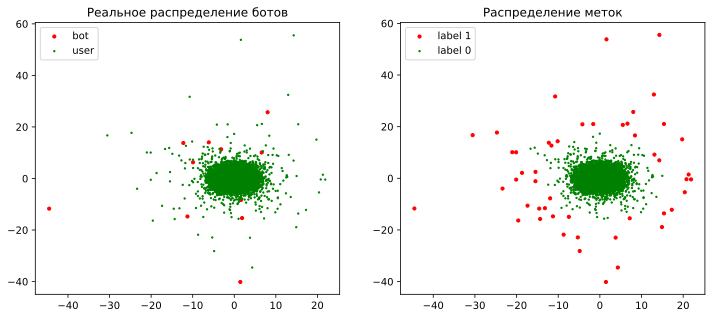

In [17]:
plot_2d_distr_scatter(X_mds, y_sample, y_labels)

In [15]:
kf=KFold(n_splits=50, random_state=42, shuffle=True)
eps = 1.2
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_mds = manifold.MDS(n_components=2, n_init=1, n_jobs=-1, max_iter=10).fit_transform(X_sample)
    y_labels, eps = my_db_scan(X_mds, min_samples=1, eps=eps, min_bot_num=30, max_bot_num=150, verbose=False)
    temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('adaptive_mds_2.csv')

100%|██████████| 50/50 [06:51<00:00,  8.26s/it]


Всего ботов: 473
Всего отмечено: 5840
Верно отмечено: 347
Ф-мера: 0.10993188658324093
Полнота: 0.733615221987315
Точность: 0.05941780821917808


In [18]:
kf=KFold(n_splits=50, random_state=42, shuffle=True)
eps = 2
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_mds = manifold.MDS(n_components=2, n_init=1, n_jobs=-1, max_iter=10).fit_transform(X_sample)
    y_labels, eps = my_db_scan(X_mds, min_samples=1, eps=eps, min_bot_num=10, max_bot_num=35, verbose=False)
    temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('careful_mds_2.csv')

100%|██████████| 50/50 [07:31<00:00,  8.82s/it]


Всего ботов: 473
Всего отмечено: 1261
Верно отмечено: 176
Ф-мера: 0.20299884659746253
Полнота: 0.37209302325581395
Точность: 0.13957176843774782


Построим 4 различных разбиений исходного датасета, а затем посмотрим, как часто та или иная транзакция была отмечена как аномальная

In [19]:
for random_state in {12, 15, 20, 24, 36}:
    kf=KFold(n_splits=50, random_state=random_state, shuffle=True)
    eps = 1.7
    res_labels = pd.DataFrame()
    for i in tqdm(kf.split(X), total=kf.n_splits):
        X_sample = X.loc[i[1]]
        y_sample = y[i[1]]
        X_mds = manifold.MDS(n_components=2, n_init=1, n_jobs=-1, max_iter=10).fit_transform(X_sample)
        y_labels, eps = my_db_scan(X_mds, min_samples=1, eps=eps, min_bot_num=15, max_bot_num=40, verbose=False)
        temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_{}'.format(random_state)])
        res_labels = res_labels.append(temp_df)
    res_labels.sort_index(inplace=True)
    print('Всего ботов: {}'.format(y.sum()))
    print('Всего отмечено: {}'.format(res_labels.sum()[0]))
    print('Верно отмечено: {}'.format(len([x for x in np.where(
        y==1)[0] if x in np.where(res_labels.values==1)[0]])))
    print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
    print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
    print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
    res_labels.to_csv('mds_2_{}.csv'.format(random_state))

100%|██████████| 50/50 [07:15<00:00,  8.59s/it]


Всего ботов: 473
Всего отмечено: 1390
Верно отмечено: 184
Ф-мера: 0.19753086419753085
Полнота: 0.3890063424947146
Точность: 0.13237410071942446


100%|██████████| 50/50 [07:16<00:00,  8.67s/it]


Всего ботов: 473
Всего отмечено: 1433
Верно отмечено: 181
Ф-мера: 0.18992654774396642
Полнота: 0.38266384778012685
Точность: 0.12630844382414516


100%|██████████| 50/50 [07:12<00:00,  8.58s/it]


Всего ботов: 473
Всего отмечено: 1558
Верно отмечено: 191
Ф-мера: 0.1880846873461349
Полнота: 0.40380549682875266
Точность: 0.12259306803594351


100%|██████████| 50/50 [07:14<00:00,  8.57s/it]


Всего ботов: 473
Всего отмечено: 1477
Верно отмечено: 201
Ф-мера: 0.20615384615384616
Полнота: 0.4249471458773784
Точность: 0.13608666215301288


100%|██████████| 50/50 [07:18<00:00,  8.98s/it]


Всего ботов: 473
Всего отмечено: 1381
Верно отмечено: 184
Ф-мера: 0.19848975188781012
Полнота: 0.3890063424947146
Точность: 0.1332367849384504


In [30]:
summary = pd.DataFrame()
for random_state in {12, 15, 20, 24, 36}:
    summary['rs_{}'.format(random_state)] = pd.read_csv(
        'mds_2_{}.csv'.format(random_state), index_col=0).iloc[:, 0]
summary['overall'] = summary.sum(axis=1)
summary.head()

rs_36  rs_12  rs_15  rs_20  rs_24  overall
0      0      0      0      0      0        0
1      0      0      0      0      0        0
2      0      0      0      0      0        0
3      0      0      0      0      0        0
4      0      0      0      0      0        0

In [31]:
summary.overall.value_counts()

0    273492
5       897
1       511
2       292
4       246
3       225
Name: overall, dtype: int64

In [44]:
summary_labels = np.array(summary.overall > 4, dtype=np.int8)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(summary_labels.sum()))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(summary_labels==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=summary_labels, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=summary_labels, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=summary_labels, y_true=y)))

Всего ботов: 473
Всего отмечено: 897
Верно отмечено: 144
Ф-мера: 0.21021897810218979
Полнота: 0.3044397463002114
Точность: 0.1605351170568562


### MDS-3

In [47]:
X_sample, y_sample = get_random_sample(X, y, 5000)
X_mds = manifold.MDS(n_components=3, n_init=1, n_jobs=-1, max_iter=10).fit_transform(X_sample)
y_labels, _ = my_db_scan(X_mds, min_samples=1, eps=4, min_bot_num=10, max_bot_num=50)

Текущий параметр: 4
Всего отмечено: 57
Текущий параметр: 4.1
Всего отмечено: 56
Текущий параметр: 4.199999999999999
Всего отмечено: 53
Текущий параметр: 4.299999999999999
Всего отмечено: 52
Текущий параметр: 4.399999999999999
Всего отмечено: 50
Всего ботов: 8
Верно отмечено: 5
Ф-мера: 0.1724137931034483
Полнота: 0.625
Точность: 0.1


In [48]:
plot_3d_distr_scatter(X_mds, y_sample, y_labels)

In [49]:
kf=KFold(n_splits=50, random_state=42, shuffle=True)
eps = 4
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_mds = manifold.MDS(n_components=3, n_init=1, n_jobs=-1, max_iter=10).fit_transform(X_sample)
    y_labels, eps = my_db_scan(X_mds, min_samples=1, eps=eps, min_bot_num=10, max_bot_num=35, verbose=False)
    temp_df = pd.DataFrame(index=i[1], data=y_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('careful_mds_3.csv')

100%|██████████| 50/50 [08:30<00:00,  9.65s/it]


Всего ботов: 473
Всего отмечено: 1204
Верно отмечено: 173
Ф-мера: 0.20632081097197374
Полнота: 0.3657505285412262
Точность: 0.143687707641196


В целом нельзя сказать, что получились результаты на порядок лучше, чем mds-2. Однако считается довольно шустро.

Попробуем аналогичную суммарную таблицу построить по всем нашим исследованиям.

In [58]:
import os
path_list = [path for path in os.listdir() if 'csv' in path and 'data' not in path and 'target' not in path]
summary = pd.DataFrame()
for i, path in enumerate(path_list):
    summary['research_{}'.format(i)] = pd.read_csv(path, index_col=0).iloc[:, 0]
summary['overall'] = summary.sum(axis=1)
summary.overall.value_counts()

0     269464
1       3030
2        747
12       515
3        419
4        296
5        252
9        212
8        168
6        161
7        160
11       125
10       114
Name: overall, dtype: int64

In [68]:
summary_labels = np.array(summary.overall > 7, dtype=np.int8)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(summary_labels.sum()))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(summary_labels==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=summary_labels, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=summary_labels, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=summary_labels, y_true=y)))

Всего ботов: 473
Всего отмечено: 1134
Верно отмечено: 165
Ф-мера: 0.20535158680771623
Полнота: 0.3488372093023256
Точность: 0.1455026455026455


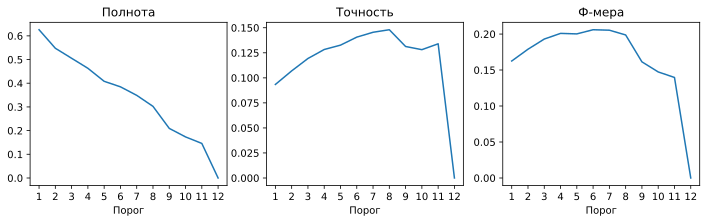

In [75]:
summary_labels = np.array(summary.overall > 7, dtype=np.int8)

plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(1, 3)        
ax1 = plt.subplot(gs[0, 0])
ax1.set_title('Полнота')
summary_list = [np.array(summary.overall > t, dtype=np.int8) for t in range(1, 13)]
recall_by_level = [recall_score(y_pred=elem, y_true=y) for elem in summary_list]
ax1.plot(range(1, 13), recall_by_level)
ax1.set_xticks(range(1, 13))
ax1.set_xlabel('Порог')

ax2 = plt.subplot(gs[0, 1])
ax2.set_title('Точность')
precision_by_level = [precision_score(y_pred=elem, y_true=y) for elem in summary_list]
ax2.plot(range(1, 13), precision_by_level)
ax2.set_xticks(range(1, 13))
ax2.set_xlabel('Порог')

ax3 = plt.subplot(gs[0, 2])
ax3.set_title('Ф-мера')
f1_by_level = [f1_score(y_pred=elem, y_true=y) for elem in summary_list]
ax3.plot(range(1, 13), f1_by_level)
ax3.set_xticks(range(1, 13))
ax3.set_xlabel('Порог')
del(summary_list)
plt.show()

В общем по графикам видно, что 7-8 хорошее значение порога на сумму меток

### One class svm

Буду пробовать на самых удачных конфигурациях, а именно на pca-10 и mds-3



In [125]:
from sklearn.svm import OneClassSVM
kf=KFold(n_splits=5, random_state=42, shuffle=True)
pca = PCA(n_components=10).fit(X)
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_pca = pca.transform(X_sample)
    clf = OneClassSVM(kernel='rbf', random_state=42, nu=0.011, gamma=0.03)
    clf.fit(X_pca)
    final_labels = (clf.predict(X_pca) + 1) / 2
    labels_counter = Counter(final_labels)
    if labels_counter[1] > labels_counter[0]:
        final_labels = -final_labels + 1
    temp_df = pd.DataFrame(index=i[1], data=final_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('ocsvm_pca_10.csv')

100%|██████████| 5/5 [00:24<00:00,  4.80s/it]


Всего ботов: 473
Всего отмечено: 3038.0
Верно отмечено: 219
Ф-мера: 0.12475078325263458
Полнота: 0.4630021141649049
Точность: 0.07208689927583936


Очень быстро, но тяжело контролировать точность: параметры влияют не так очевидно, как в случае с DBSCAN

In [140]:
from sklearn.svm import OneClassSVM
kf=KFold(n_splits=50, random_state=42, shuffle=True)
res_labels = pd.DataFrame()
for i in tqdm(kf.split(X), total=kf.n_splits):
    X_sample = X.loc[i[1]]
    y_sample = y[i[1]]
    X_mds = manifold.MDS(n_components=3, n_init=1, n_jobs=-1, max_iter=10).fit_transform(X_sample)
    clf = OneClassSVM(kernel='rbf', random_state=42, nu=0.012, gamma=0.03)
    clf.fit(X_mds)
    final_labels = (clf.predict(X_mds) + 1) / 2
    labels_counter = Counter(final_labels)
    if labels_counter[1] > labels_counter[0]:
        final_labels = -final_labels + 1
    temp_df = pd.DataFrame(index=i[1], data=final_labels, columns=['random_state_42'])
    res_labels = res_labels.append(temp_df)
res_labels.sort_index(inplace=True)
print('Всего ботов: {}'.format(y.sum()))
print('Всего отмечено: {}'.format(res_labels.sum()[0]))
print('Верно отмечено: {}'.format(len([x for x in np.where(
    y==1)[0] if x in np.where(res_labels.values==1)[0]])))
print('Ф-мера: {}'.format(f1_score(y_pred=res_labels.values, y_true=y)))
print('Полнота: {}'.format(recall_score(y_pred=res_labels.values, y_true=y)))
print('Точность: {}'.format(precision_score(y_pred=res_labels.values, y_true=y)))
res_labels.to_csv('ocsvm_mds_2.csv')


  0%|          | 0/50 [00:00<?, ?it/s]








100%|██████████| 50/50 [07:11<00:00,  8.54s/it]


Всего ботов: 473
Всего отмечено: 6592.0
Верно отмечено: 264
Ф-мера: 0.07473460721868366
Полнота: 0.5581395348837209
Точность: 0.04004854368932039


Проблемы все те же, только теперь еще и считается дольше. В целом возможна лучшая работа алгоритма при более аккуратной настройке параметров, однако как автоматизировать их настройку пока особо идей нет. Возможно при этом получится использовать этот алгоритм как предварительное сито например, так как работает на готовых признаках очень быстро

### Ransac
Ну идея - предсказывать значение USD по остальным колонкам на отдельных выборках. В выборках где получилось относительно небольшое значение функции потерь считаем, что выбросов нет, и соответственно отмечаем те точки.
Алгоритм стохастический, к его завершению получаем некоторую маску на точки, которая говорит, является ли та или иная точка outlier-ом.

In [ ]:
from sklearn.linear_model import RANSACRegressor, Ridge
base_clf = Ridge(alpha=1)
clf = RANSACRegressor(base_estimator=base_clf, min_samples=0.01, max_trials=10000, stop_n_inliers=280000)

X_prev = X.drop('USD', 1)
y_now = X.USD
clf.fit(X_prev, y_now)

### Заключение

В общем такие подходы я поиспользовал, на каком именно решении следует остановиться и конкретный пул параметров зависит от конкретной постановки задачи, как много ошибок первого и второго рода нам допустимы. В целом, как мне кажется, большой зоопарк методов идет только на пользу, как минимум для возможности оценки ботов по сразу нескольким критериям.

Пока лучшее, что я увидел - это чистый dbscan и dbscan после PCA-10 и MDS-2,3